Loading SAM model...
Using device: cpu


C:\Users\2012b\AppData\Local\Temp\ipykernel_26852\4087741594.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=devic

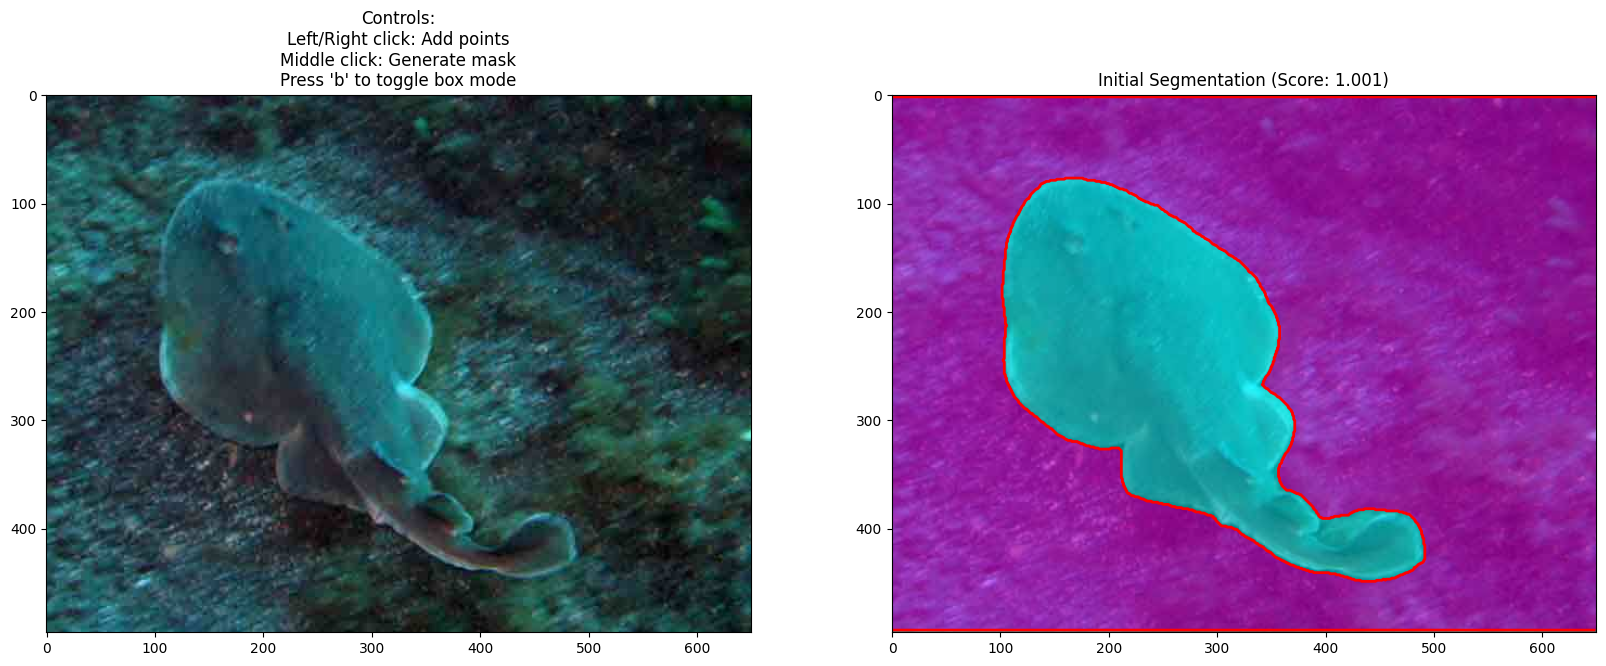

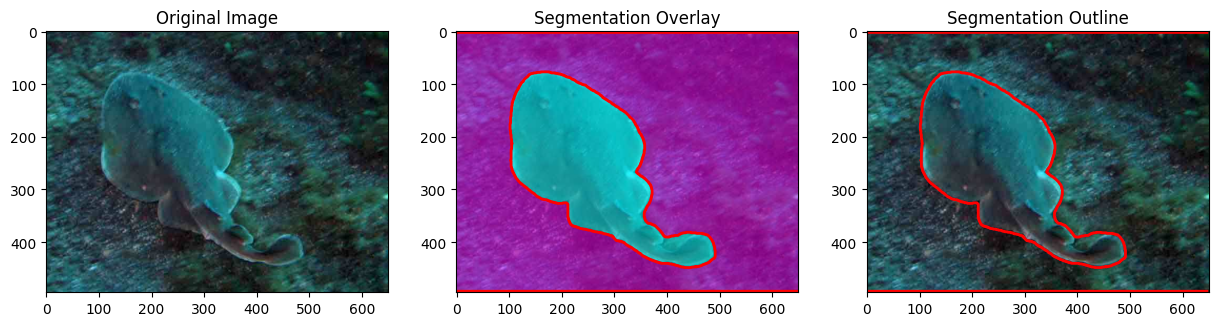

In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
import os

def load_sam():
    checkpoint_path = "../checkpoints/sam_vit_h_4b8939.pth"
    model_type = "vit_h"
    
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"SAM checkpoint not found at {checkpoint_path}")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Initialize the SAM model with the specified type
    sam = sam_model_registry[model_type]()
    
    # Load the state dictionary
    state_dict = torch.load(checkpoint_path, map_location=device)
    sam.load_state_dict(state_dict)
    sam.to(device=device)
    
    return sam, device

class InteractiveSAM:
    def __init__(self, sam, device):
        self.predictor = SamPredictor(sam)
        self.device = device
        self.points = []
        self.point_labels = []
        self.current_mask = None
        self.box_start = None
        self.box_end = None
        self.drawing_box = False
        self.box_mode = False  # Added box mode toggle
        
    def set_image(self, image_path):
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found at: {image_path}")
                
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Failed to load image at: {image_path}")
                
        self.image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        self.predictor.set_image(self.image)
            
        # Get image dimensions
        self.height, self.width = self.image.shape[:2]
            
    def generate_full_image_mask(self):
        # Create a box that covers the entire image
        input_box = np.array([0, 0, self.width, self.height])
            
        masks, scores, logits = self.predictor.predict(
            box=input_box[None, :],
            multimask_output=True
        )
            
        best_mask_idx = np.argmax(scores)
        self.current_mask = masks[best_mask_idx]
        return self.current_mask, scores[best_mask_idx]
            
    def interactive_segment(self):
        if not hasattr(self, 'image'):
            raise ValueError("No image has been set. Please call set_image() first.")
                
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        ax1.imshow(self.image)
        ax2.imshow(self.image)
        ax1.set_title("Controls:\nLeft/Right click: Add points\nMiddle click: Generate mask\nPress 'b' to toggle box mode")
        ax2.set_title("Segmentation Result")
            
        # Initialize rectangle for box drawing
        self.box_rect = None
        
        # Generate and display initial mask
        initial_mask, score = self.generate_full_image_mask()
        ax2.clear()
        ax2.imshow(self.image)
        ax2.imshow(initial_mask, alpha=0.5, cmap='cool')
        ax2.contour(initial_mask, colors='red', linewidths=2)
        ax2.set_title(f"Initial Segmentation (Score: {score:.3f})")
            
        def on_key_press(event):
            if event.key == 'b':
                self.box_mode = not self.box_mode
                mode = "ON" if self.box_mode else "OFF"
                print(f"Box mode toggled {mode}")

        def on_button_press(event):
            if event.inaxes == ax1:
                if self.box_mode and event.button == 1:  # Left click starts box
                    self.drawing_box = True
                    self.box_start = [event.xdata, event.ydata]
                elif not self.box_mode:
                    if event.button in [1, 3]:  # Left or right click for points
                        self.points.append([event.xdata, event.ydata])
                        self.point_labels.append(1 if event.button == 1 else 0)
                            
                        color = 'go' if event.button == 1 else 'ro'
                        ax1.plot(event.xdata, event.ydata, color, markersize=10)
                        plt.draw()
                    elif event.button == 2:  # Middle click to generate mask
                        self.generate_mask(ax2)
                    
        def on_button_release(event):
            if self.drawing_box and event.inaxes == ax1:
                self.drawing_box = False
                self.box_end = [event.xdata, event.ydata]
                self.draw_box(ax1)
                self.generate_mask_with_box(ax2)
                plt.draw()
                
        def on_motion(event):
            if self.drawing_box and event.inaxes == ax1:
                if self.box_rect:
                    self.box_rect.remove()
                x0, y0 = self.box_start
                x1, y1 = event.xdata, event.ydata
                self.box_rect = plt.Rectangle((min(x0, x1), min(y0, y1)), 
                                              abs(x1 - x0), abs(y1 - y0),
                                              fill=False, color='yellow', linewidth=2)
                ax1.add_patch(self.box_rect)
                plt.draw()
                
        fig.canvas.mpl_connect('key_press_event', on_key_press)
        fig.canvas.mpl_connect('button_press_event', on_button_press)
        fig.canvas.mpl_connect('button_release_event', on_button_release)
        fig.canvas.mpl_connect('motion_notify_event', on_motion)
        plt.show()
            
        return self.current_mask
        
    def draw_box(self, ax):
        if self.box_start and self.box_end:
            x0, y0 = self.box_start
            x1, y1 = self.box_end
            if self.box_rect:
                self.box_rect.remove()
            self.box_rect = plt.Rectangle((min(x0, x1), min(y0, y1)), 
                                          abs(x1 - x0), abs(y1 - y0),
                                          fill=False, color='yellow', linewidth=2)
            ax.add_patch(self.box_rect)
            plt.draw()
        
    def generate_mask(self, ax):
        if len(self.points) > 0:
            input_points = np.array(self.points)
            input_labels = np.array(self.point_labels)
                
            masks, scores, logits = self.predictor.predict(
                point_coords=input_points,
                point_labels=input_labels,
                multimask_output=True
            )
                
            best_mask_idx = np.argmax(scores)
            self.current_mask = masks[best_mask_idx]
                
            ax.clear()
            ax.imshow(self.image)
            ax.imshow(self.current_mask, alpha=0.5, cmap='cool')
            ax.contour(self.current_mask, colors='red', linewidths=2)
            ax.set_title(f"Segmentation Result (Score: {scores[best_mask_idx]:.3f})")
            plt.draw()
    
    def generate_mask_with_box(self, ax):
        if self.box_start and self.box_end:
            x0, y0 = self.box_start
            x1, y1 = self.box_end
            input_box = np.array([min(x0, x1), min(y0, y1), max(x0, x1), max(y0, y1)])
                
            masks, scores, logits = self.predictor.predict(
                point_coords=np.array(self.points) if len(self.points) > 0 else None,
                point_labels=np.array(self.point_labels) if len(self.points) > 0 else None,
                box=input_box[None, :],
                multimask_output=True
            )
                
            best_mask_idx = np.argmax(scores)
            self.current_mask = masks[best_mask_idx]
                
            ax.clear()
            ax.imshow(self.image)
            ax.imshow(self.current_mask, alpha=0.5, cmap='cool')
            ax.contour(self.current_mask, colors='red', linewidths=2)
            ax.set_title(f"Segmentation Result (Score: {scores[best_mask_idx]:.3f})")
            plt.draw()

def main():
    try:
        # Load model
        print("Loading SAM model...")
        sam, device = load_sam()
        
        # Create interactive segmentation instance
        interactive_sam = InteractiveSAM(sam, device)
        
        # Set image path
        image_path = "../data/raw/test/n01496331_3.jpg"
        
        try:
            interactive_sam.set_image(image_path)
        except (FileNotFoundError, ValueError) as e:
            print(f"Error: {e}")
            return
        
        mask = interactive_sam.interactive_segment()
        
        # Display results
        if mask is not None:
            plt.figure(figsize=(15, 5))
            
            plt.subplot(131)
            plt.imshow(interactive_sam.image)
            plt.title("Original Image")
            
            plt.subplot(132)
            plt.imshow(interactive_sam.image)
            plt.imshow(mask, alpha=0.5, cmap='cool')
            plt.contour(mask, colors='red', linewidths=2)
            plt.title("Segmentation Overlay")
            
            plt.subplot(133)
            plt.imshow(interactive_sam.image)
            plt.contour(mask, colors='red', linewidths=2)
            plt.title("Segmentation Outline")
            
            plt.show()
                    
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()
